In [76]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Image properties 

In [77]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

### Load Data

In [78]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [79]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [80]:
len(dataset)

68

### Visualization

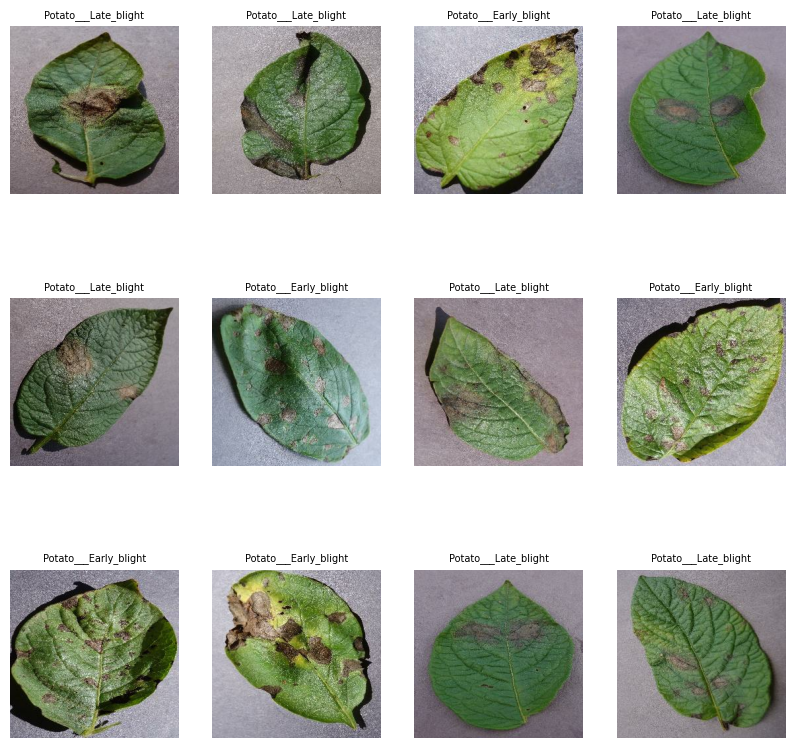

In [81]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    #print(image_batch.shape)#(32, 256, 256, 3)
    #print(label_batch.numpy())#[1 1 0 1 0 1 0 2 0 0 0 1 1 0 1 1 1 2 1 0 0 2 1 1 1 1 1 0 1 0 0 0]
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]],fontsize=7)
        plt.axis("off")
    

In [82]:
len(dataset)

68

In [83]:
# 80% ==> training
# 20% ==> 10%validation, 10% test

### Partitioning

In [84]:
def data_partitions(ds,train_split,val_split,test_split,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)

    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size)
    val_ds=test_ds.take(val_size)
    test_ds=test_ds.skip(val_size)

    return train_ds,val_ds, test_ds
    

In [85]:
train_ds,val_ds,test_ds=data_partitions(dataset,0.8,0.1,0.1)

In [86]:
len(train_ds)

54

In [87]:
len(val_ds)

6

In [88]:
len(test_ds)

8

In [89]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Preprocessing 

### Create the layers 

* Rescaling and Resizing

In [90]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

* Augmentation

In [91]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

### Model Building

In [92]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [93]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [94]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [95]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 144s 2s/step - loss: 0.9172 - accuracy: 0.4821 - val_loss: 0.8931 - val_accuracy: 0.5417
Epoch 2/50
54/54 [==============================] - 122s 2s/step - loss: 0.6582 - accuracy: 0.7083 - val_loss: 0.7550 - val_accuracy: 0.6302
Epoch 3/50
54/54 [==============================] - 112s 2s/step - loss: 0.4395 - accuracy: 0.8275 - val_loss: 0.3614 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 123s 2s/step - loss: 0.3413 - accuracy: 0.8727 - val_loss: 0.3023 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 168s 3s/step - loss: 0.2377 - accuracy: 0.9016 - val_loss: 0.3647 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 148s 3s/step - loss: 0.2026 - accuracy: 0.9126 - val_loss: 0.3232 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 102s 2s/step - loss: 0.2178 - accuracy: 0.9074 - val_loss: 0.3040 - val_accuracy: 0.8854
Epoch 8/50
54

In [96]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 417ms/step - loss: 0.0842 - accuracy: 0.9688


In [97]:
scores

[0.08423762023448944, 0.96875]

In [98]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [99]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [100]:
history.history['accuracy']

[0.48206019401550293,
 0.7083333134651184,
 0.8275462985038757,
 0.8726851940155029,
 0.9016203880310059,
 0.9126157164573669,
 0.9074074029922485,
 0.921875,
 0.9247685074806213,
 0.9409722089767456,
 0.9288194179534912,
 0.9340277910232544,
 0.953125,
 0.9403935074806213,
 0.9467592835426331,
 0.9438657164573669,
 0.9571759104728699,
 0.9525462985038757,
 0.953125,
 0.9606481194496155,
 0.9594907164573669,
 0.953125,
 0.9450231194496155,
 0.9629629850387573,
 0.9710648059844971,
 0.9635416865348816,
 0.9739583134651184,
 0.9646990895271301,
 0.9641203880310059,
 0.9762731194496155,
 0.9670138955116272,
 0.9739583134651184,
 0.9739583134651184,
 0.9675925970077515,
 0.9785879850387573,
 0.9641203880310059,
 0.9739583134651184,
 0.9820601940155029,
 0.984375,
 0.9855324029922485,
 0.9791666865348816,
 0.9832175970077515,
 0.96875,
 0.9803240895271301,
 0.9832175970077515,
 0.9814814925193787,
 0.9803240895271301,
 0.9739583134651184,
 0.9872685074806213,
 0.9872685074806213]

In [101]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

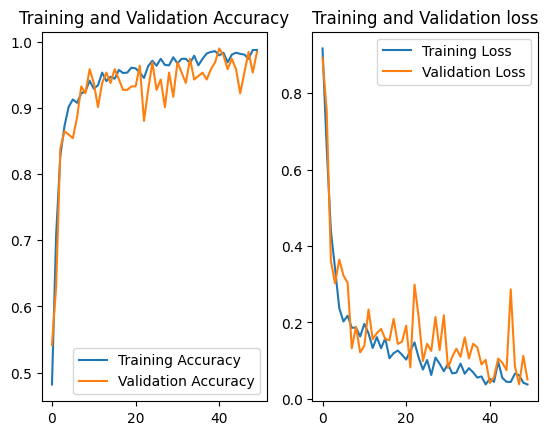

In [102]:
# plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

### Prediction Part

First image to predict
actual label : Potato___Early_blight
1/1 [==============================] - 1s 966ms/step
Predict label Potato___Early_blight


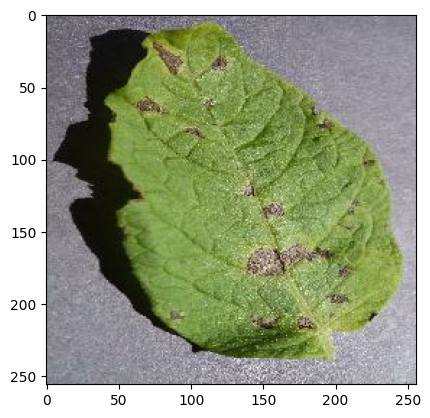

In [103]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print("actual label :", class_names[first_label])

    batch_prediction=model.predict(images_batch)
    # print(batch_prediction[0])
    print("Predict label",class_names[np.argmax(batch_prediction[0])])

In [104]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#Create a batch

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence


1/1 [==============================] - 0s 42ms/step


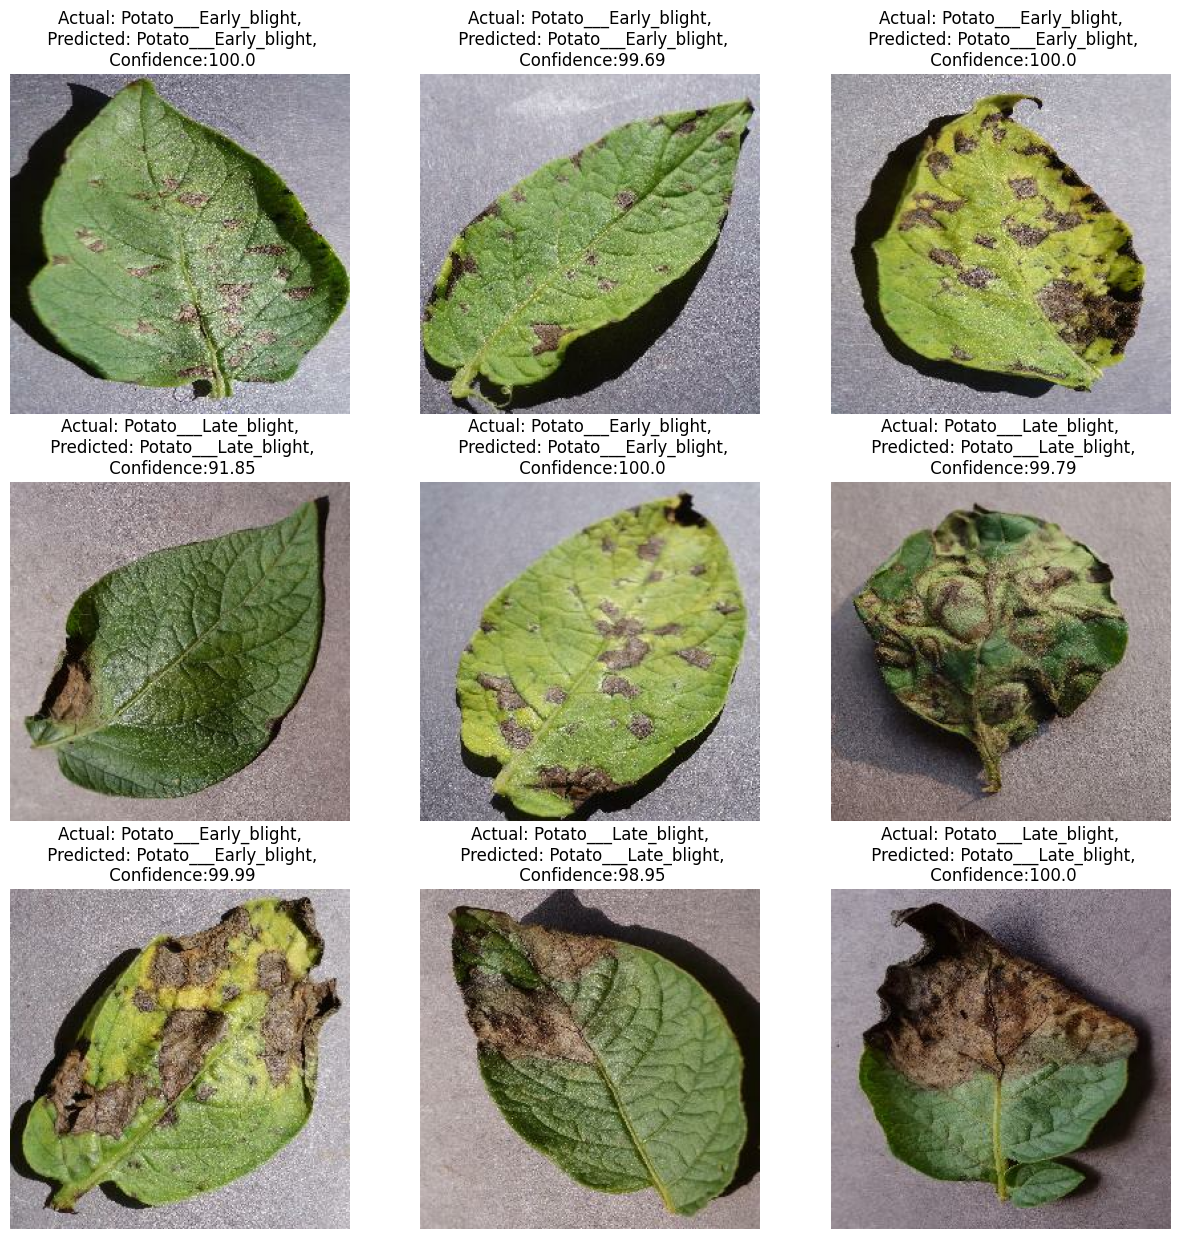

In [105]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range (9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")

In [106]:
model_version=1
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/1\assets


INFO:tensorflow:Assets written to: ./Models/1\assets


In [107]:
batch_prediction

array([[9.9947459e-01, 5.2532938e-04, 1.7217560e-07],
       [9.9854076e-01, 1.4592891e-03, 1.3161981e-10],
       [9.9999988e-01, 1.4513317e-07, 2.8679702e-14],
       [1.6630979e-04, 8.0179864e-01, 1.9803511e-01],
       [6.0936512e-05, 3.4550697e-01, 6.5443212e-01],
       [9.9999797e-01, 1.9695040e-06, 1.4631560e-12],
       [9.9068320e-01, 9.3166502e-03, 8.6653714e-08],
       [9.9998951e-01, 1.0532516e-05, 4.1165026e-11],
       [1.0405182e-11, 8.5213868e-04, 9.9914789e-01],
       [4.7383924e-06, 9.9892920e-01, 1.0660295e-03],
       [3.3827822e-04, 9.9855679e-01, 1.1049216e-03],
       [9.9985981e-01, 1.4011288e-04, 1.1106812e-08],
       [6.5628005e-09, 1.1857074e-03, 9.9881434e-01],
       [3.2263717e-01, 6.7726082e-01, 1.0201989e-04],
       [9.9715436e-01, 2.8454571e-03, 1.5175053e-07],
       [3.1879970e-06, 9.9991286e-01, 8.3864586e-05],
       [1.0637979e-04, 9.9988627e-01, 7.3798765e-06],
       [9.9802494e-01, 1.9751179e-03, 8.8066976e-09],
       [9.9949481e-05, 9.998

In [108]:
predicted_class=[np.argmax(i) for i in batch_prediction]

In [ ]:
cm=tf.math.confusion_matrix(labels=,predictions=)